# Visualize XAI
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 20, 2022


## Python stuff

In [ ]:
import sys, os, copy
import importlib as imp

import cmocean
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy as ct
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import silence_tensorflow
silence_tensorflow

import scipy.stats as stats
import seaborn as sns
import cmaps as cmaps_ncl

import experiment_settings
import file_methods, plots, data_processing, xai

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [ ]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

## User Choices

In [ ]:
EXP_NAME = 'exp11C_370'#'exp15C_370'

#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Initial housekeeping

In [ ]:
# get seed to plot
df_metrics = pd.read_pickle(PREDICTIONS_DIRECTORY + "df_random_seed.pickle")
df = df_metrics[df_metrics["exp_name"]==EXP_NAME]
PLOT_SEED = df_metrics.iloc[df['loss_val'].idxmin()]["seed"]
PLOT_SEED = 2247
print('PLOT_SEED = ' + str(PLOT_SEED))

## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# load observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

## Plotting Functions

In [ ]:
def set_cb_xai(cb):
    cb.set_label(None)
    cb.ax.set_xticks((-0.05,0.05))    
    cb.ax.set_xticklabels(['further\nfrom threshold','nearer\nto threshold'],
                          fontsize=FS*.8,
                         )    
    

In [ ]:
FS = 10

### for white background...
plt.rc('text',usetex=False)
# plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Load the Model

In [ ]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

# get the cmip data
(x_train, 
 x_val, 
 x_test, 
 y_train, 
 y_val, 
 y_test, 
 onehot_train, 
 onehot_val, 
 onehot_test, 
 y_yrs_train, 
 y_yrs_val, 
 y_yrs_test, 
 target_years, 
 map_shape,
 settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings)


# get model name
model_name = file_methods.get_model_name(settings)
model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)

## XAI for CMIP models

In [ ]:
imp.reload(xai)
#=========================================
# Define the samples you want to explain
rng_subsample = np.random.default_rng(999)
top_pred_idx = 0
isubsample = rng_subsample.choice(np.arange(0,x_test.shape[0]),
                        size = np.min((500,x_test.shape[0])),
                        replace = False,
                       )

inputs = np.copy(x_test[isubsample,:])
targets = np.copy(y_test[isubsample])
yrs = np.copy(y_yrs_test[isubsample])
preds = model.predict(inputs)

#=========================================
#---------------------------------------
# Gradient x Input
#---------------------------------------
# compute the multiplication of gradient * inputs
# and reshape into a map of latitude x longitude

grads = xai.get_gradients(model,inputs,top_pred_idx).numpy()
grad_x_input = grads * inputs
grad_x_input = grad_x_input.reshape((len(targets),map_shape[0],map_shape[1]))
print(np.shape(grad_x_input))

#---------------------------------------
# Integrated Gradients
#---------------------------------------
baseline_mean = np.mean(x_train,axis=0)*0.    
print('shape(baseline_mean) = ' + str(np.shape(baseline_mean)))
print('model.predict(baseline_mean) = ' + str(model.predict(baseline_mean[np.newaxis,:])))

igrad = xai.get_integrated_gradients(model,inputs, baseline=baseline_mean,top_pred_idx=top_pred_idx)
integrated_gradients = igrad.numpy().reshape((len(targets),map_shape[0],map_shape[1]))
print(np.shape(integrated_gradients))

In [ ]:
map_proj = ct.crs.EqualEarth(central_longitude = 0.)

# plot the resulting heatmaps for a subset of samples
# based on their label
plot_list = (21, 1)
NCOL = 4
if settings["ssp"]=="126":
    clim_val = .1
else:
    clim_val = .05

fig = plt.figure(figsize=(4*len(plot_list),10))
# plt.subplots(len(plot_list),NCOL,figsize=(35,5*len(plot_list)))

for irow,min_range in enumerate(plot_list):
        
    max_range = min_range + 4
    isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
    igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
    grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)
    grad_mean = np.mean(grads[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
    x_inputs_mean = np.mean(inputs[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
    x_inputs_mean = x_inputs_mean - baseline_mean.reshape((map_shape[0],map_shape[1]))
    #------------------------------------------------------------------
    
    text = (
            "\n"
            + f"  label_range    = {min_range}-{max_range} yrs.\n"                    
            + f"  n_samples      = {len(isamples)}\n"
    )  
    print(text)
    #------------------------------------------------------------------    
    # plot average input map
    ax = fig.add_subplot(NCOL,len(plot_list),irow+1,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=x_inputs_mean, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap=cmaps_ncl.BlueDarkRed18,
                      vmin= -4.5, 
                      vmax= 4.5, 
                      inc=None, 
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    ax.set_title('Temperature Anomaly\n' + str(min_range) + '-' + str(max_range) + ' yrs. before threshold',fontsize=FS)
    
    #------------------------------------------------------------------
    # plot explainability of gradient (saliency)    
    ax = fig.add_subplot(NCOL,len(plot_list),3+irow,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=grad_mean*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      vmin= -clim_val, 
                      vmax= clim_val, 
                      inc=None, 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    set_cb_xai(cb)    
    ax.set_title('Gradient',fontsize=FS)    
        
#     #------------------------------------------------------------------
#     # plot explainability of input x gradient
    ax = fig.add_subplot(NCOL,len(plot_list),5+irow,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=grad_x_input_mean*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      vmin= -clim_val, 
                      vmax= clim_val, 
                      inc=None, 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    set_cb_xai(cb)    
    ax.set_title('Gradient x Input',fontsize=FS)    

#     #------------------------------------------------------------------
#     # plot explainability of integrated gradients
    ax = fig.add_subplot(NCOL,len(plot_list),7+irow,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=igrad_mean*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      vmin= -clim_val, 
                      vmax= clim_val, 
                      inc=None, 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      cbarBool=True, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    set_cb_xai(cb)
    ax.set_title('Integrated Gradients',fontsize=FS) 
    
plt.tight_layout()   
plots.savefig(FIGURE_DIRECTORY + model_name + '_cmip_xaiGrid',dpi=savefig_dpi)              
plt.show()



## XAI for Models and Obs

In [ ]:
imp.reload(plots)
map_proj = ct.crs.EqualEarth(central_longitude = 0.)
fig = plt.figure(figsize=(3.,3.75))

n_plot = 4
top_pred_idx=0
if settings["ssp"]=="126":
    clim_val = .1
else:
    clim_val = .05


for iloop,map_type in enumerate(('cmip','obs')):
    if(map_type=='cmip'):
        if(settings["target_temp"]==2.0):
            min_range = 30
            clim_val = clim_val*2
        else:
            min_range = 10
        max_range = min_range + 5
        isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
        igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
        grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)        
        plot_grads = grad_x_input_mean.reshape((len(da_obs['lat']),len(da_obs['lon']))) 
        
        cbarBool = False
        title_text = '(a) CMIP6 ' + str(min_range) + '-' + str(max_range) + ' yrs to threshold'
        
    elif(map_type=='obs'):
        grads_obs = xai.get_gradients(model,x_obs[-n_plot:,:],top_pred_idx=top_pred_idx).numpy()*x_obs[-n_plot:,:]
        print('np.shape(grads_obs) = ' + str(np.shape(grads_obs)))
        grad_x_input_obs = grads_obs * x_obs[-n_plot:,:]
        grad_x_input_obs = grad_x_input_obs.reshape((n_plot,map_shape[0],map_shape[1]))
        grad_x_input_obs_mean = np.mean(grad_x_input_obs,axis=0)        
        plot_grads = grad_x_input_obs_mean

        cbarBool = True
        title_text = '(b) Observations ' + str(2021-n_plot+1) + '-' + str(2021) 
        
    else:
        raise NotImplemented('no such map_type')
    
    ax = fig.add_subplot(2,1,iloop+1,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=plot_grads*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      vmin= -clim_val, 
                      vmax= clim_val, 
                      inc=None, 
                      cbarBool=cbarBool, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=False, 
                      extent='both',
                     )
    ax.set_title(title_text, fontsize=FS*1.0)
    if cbarBool:
        cb.set_label(None)
        cb.ax.set_xticks((-clim_val,clim_val))
        cb.ax.set_xticklabels(['further\nfrom threshold','nearer\nto threshold'],
                              fontsize=FS*.8,
                             )
        
plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name + '_cmip_obs_xai_grad_x_input',dpi=savefig_dpi)              
plt.show()

# Comparing XAI for all four observational data sets

In [23]:
settings["obsdata"] = 'BEST'
da_obs_best, x_obs_best, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_best = data_processing.compute_global_mean(da_obs_best)

settings["obsdata"] = 'BESTANOM'
da_obs_besta, x_obs_besta, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_besta = data_processing.compute_global_mean(da_obs_best)

settings["obsdata"] = 'GISS'
da_obs_giss, x_obs_giss, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_giss = data_processing.compute_global_mean(da_obs_giss)

settings["obsdata"] = 'NCEP'
da_obs_ncep, x_obs_ncep, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_ncep = data_processing.compute_global_mean(da_obs_ncep)

settings["obsdata"] = 'ERA5'
da_obs_era, x_obs_era, __ = data_processing.get_observations(DATA_DIRECTORY, settings)
global_mean_obs_era = data_processing.compute_global_mean(da_obs_era)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (142, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (74, 10368)
observations: filling NaNs with zeros
np.shape(x_obs) = (72, 10368)


In [ ]:
# settings["obsdata"] = 'GISS'
# da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
# N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

# da_obs_giss = da_obs

# imp.reload(plots)
# map_proj = ct.crs.EqualEarth(central_longitude = 0.)
# fig = plt.figure(figsize=(3.,3.75))

# n_plot = 4
# top_pred_idx=0
# clim_val = .05

# for iloop,map_type in enumerate(('obs',)):
#     if(map_type=='cmip'):
#         if(settings["target_temp"]==2.0):
#             min_range = 30
#             clim_val = clim_val*2
#         else:
#             min_range = 10
#         max_range = min_range + 5
#         isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
#         igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
#         grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)        
#         plot_grads = grad_x_input_mean.reshape((len(da_obs['lat']),len(da_obs['lon']))) 
        
#         cbarBool = False
#         title_text = '(a) CMIP6 ' + str(min_range) + '-' + str(max_range) + ' yrs to threshold'
        
#     elif(map_type=='obs'):
#         grads_obs = xai.get_gradients(model,x_obs[-n_plot:,:],top_pred_idx=top_pred_idx).numpy()*x_obs[-n_plot:,:]
#         print('np.shape(grads_obs) = ' + str(np.shape(grads_obs)))
#         grad_x_input_obs = grads_obs * x_obs[-n_plot:,:]
#         grad_x_input_obs = grad_x_input_obs.reshape((n_plot,map_shape[0],map_shape[1]))
#         grad_x_input_obs_mean = np.mean(grad_x_input_obs,axis=0)        
#         plot_grads = grad_x_input_obs_mean

#         cbarBool = True
#         title_text = '(b) GISS - BEST ' + str(2021-n_plot+1) + '-' + str(2021) 
        
#     else:
#         raise NotImplemented('no such map_type')
    
#     ax = fig.add_subplot(2,1,iloop+1,projection=map_proj)
#     cb,image = plots.drawOnGlobe(ax, 
#                       map_proj, 
#                       data=(plot_grads-grad_best)*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
#                       lats=da_obs['lat'], 
#                       lons=da_obs['lon'], 
#                       cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
#                       vmin= -clim_val, 
#                       vmax= clim_val, 
#                       inc=None, 
#                       cbarBool=cbarBool, 
#                       contourMap=[], 
#                       contourVals = [], 
#                       fastBool=True, 
#                       extent='both',
#                      )
#     ax.set_title(title_text, fontsize=FS*1.0)
#     if cbarBool:
#         cb.set_label(None)
#         cb.ax.set_xticks((-clim_val,clim_val))
#         cb.ax.set_xticklabels(['further\nfrom threshold','nearer\nto threshold'],
#                               fontsize=FS*.8,
#                              )
        
# plt.tight_layout()
           
# plt.show()

np.shape(grads_obs) = (4, 10368)


/opt/homebrew/Caskroom/miniforge/base/envs/env-tf-cartopy/lib/python3.9/site-packages/cartopy/crs.py:982: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings.extend(multi_line_string)
/opt/homebrew/Caskroom/miniforge/base/envs/env-tf-cartopy/lib/python3.9/site-packages/cartopy/crs.py:982: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings.extend(multi_line_string)


np.shape(grads_obs) = (4, 10368)
np.shape(grads_obs) = (4, 10368)
np.shape(grads_obs) = (4, 10368)


/opt/homebrew/Caskroom/miniforge/base/envs/env-tf-cartopy/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/homebrew/Caskroom/miniforge/base/envs/env-tf-cartopy/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/homebrew/Caskroom/miniforge/base/envs/env-tf-cartopy/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part g

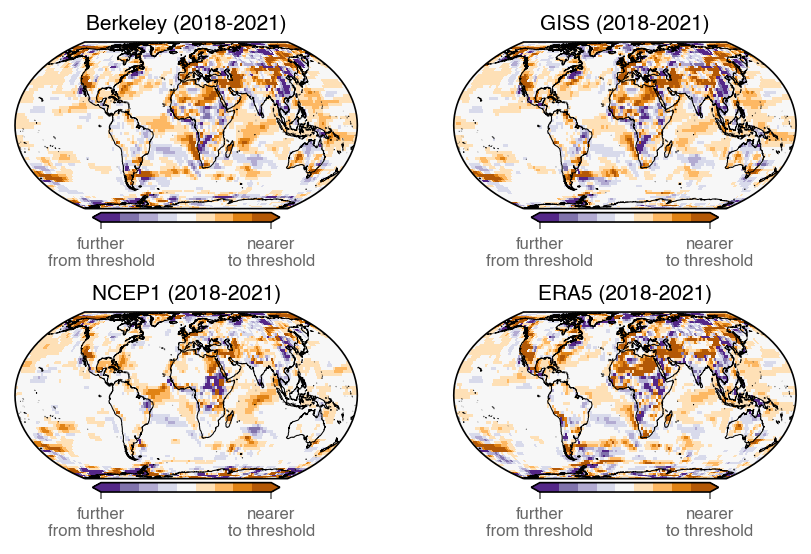

In [30]:
# settings["obsdata"] = 'GISS'
# da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
# N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)


imp.reload(plots)
map_proj = ct.crs.EqualEarth(central_longitude = 0.)
fig = plt.figure(figsize=(6.,3.75))

n_plot = 4
top_pred_idx=0
clim_val = .05

for iloop,map_type in enumerate(('Berkeley','GISS','NCEP1','ERA5')):
    
    if map_type=='Berkeley':
        x_obs = x_obs_best
    elif map_type == 'GISS':
        x_obs = x_obs_giss        
    elif map_type == 'NCEP1':
        x_obs = x_obs_ncep
    elif map_type == 'ERA5':        
        x_obs = x_obs_era    
    else:
        raise NotImplemented
        

    grads_obs = xai.get_gradients(model,x_obs[-n_plot:,:],top_pred_idx=top_pred_idx).numpy()*x_obs[-n_plot:,:]
    print('np.shape(grads_obs) = ' + str(np.shape(grads_obs)))
    grad_x_input_obs = grads_obs * x_obs[-n_plot:,:]
    grad_x_input_obs = grad_x_input_obs.reshape((n_plot,map_shape[0],map_shape[1]))
    grad_x_input_obs_mean = np.mean(grad_x_input_obs,axis=0)        
    plot_grads = grad_x_input_obs_mean

    cbarBool = True    
    ax = fig.add_subplot(2,2,iloop+1,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=(plot_grads)*-1, # multiplying by negative 1 so colorbar has warm colors on the right 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
                      vmin= -clim_val, 
                      vmax= clim_val, 
                      inc=None, 
                      cbarBool=cbarBool, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    ax.set_title(map_type + ' (2018-2021)', fontsize=FS*1.0)
    
    if cbarBool:
        cb.set_label(None)
        cb.ax.set_xticks((-clim_val,clim_val))
        cb.ax.set_xticklabels(['further\nfrom threshold','nearer\nto threshold'],
                              fontsize=FS*.8,
                             )    

        
plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + model_name + '_xai_compare_obs',dpi=savefig_dpi)                         
plt.show()

In [ ]:
# # nc_filename_obs = 'Land_and_Ocean_LatLong1_185001_202112_ann_mean_2pt5degree.nc'
# nc_filename_obs = 'gistemp1200_GHCNv4_ERSSTv5_188001_202112_ann_mean_2pt5degree.nc'
# da_obs = file_methods.get_netcdf_da(DATA_DIRECTORY + nc_filename_obs)
# x_obs = da_obs[-1]
# # x_obs[x_obs["lat"]<=-50] = np.nan
# x_obs = x_obs.values

# fig = plt.figure(figsize=(6.,3.75))
# ax = fig.add_subplot(2,1,iloop+1,projection=map_proj)
# cb,image = plots.drawOnGlobe(ax, 
#                   map_proj, 
#                   data=x_obs, # multiplying by negative 1 so colorbar has warm colors on the right 
#                   lats=da_obs['lat'], 
#                   lons=da_obs['lon'], 
#                   cmap='coolwarm',
#                   vmin= None, 
#                   vmax= None, 
#                   inc=None, 
#                   cbarBool=False, 
#                   contourMap=[], 
#                   contourVals = [], 
#                   fastBool=True, 
#                   extent='both',
#                  )



# plt.pcolor(x_obs.reshape(len(da_obs_giss["lat"]),len(da_obs_giss["lon"])),cmap='RdBu_r')
# # plt.clim(-4,4)
# plt.title('GISS in 2021')
# plt.colorbar()

In [ ]:
# da_diff = da_obs_giss - da_obs_best
# da_diff_plot = np.mean(da_diff[-1:],axis=0)

# fig = plt.figure(figsize=(3.,3.75))
# ax = fig.add_subplot(2,1,iloop+1,projection=map_proj)
# cb,image = plots.drawOnGlobe(ax, 
#                   map_proj, 
#                   data=da_diff_plot.values, # multiplying by negative 1 so colorbar has warm colors on the right 
#                   lats=da_diff['lat'], 
#                   lons=da_diff['lon'], 
#                   cmap=ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'][::-1]),#cmocean.cm.tarn,
#                   vmin= -1., 
#                   vmax= 1., 
#                   inc=None, 
#                   cbarBool=True, 
#                   contourMap=[], 
#                   contourVals = [], 
#                   fastBool=True, 
#                   extent='both',
#                  )
# ax.set_title('GISS - BEST in 2021')
# plt.show()


In [ ]:
# print('PLOT_SEED = ' + str(PLOT_SEED))